In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [13]:
import tensorflow as tf
import keras
import glob
import tqdm
import os

In [14]:
def make_pair(fpath):
  files_list = glob.glob(fpath + '/*.jpg')[:10000]
  files_list1 = []
  files_list2 = []

  target_list = []

  for path in tqdm.tqdm(files_list):
    files_list1.append(path)
    files_list2.append(path)
    target_list.append(1)

    while True:
      file = np.random.choice(files_list)
      if file != path:
        files_list1.append(path)
        files_list2.append(file)
        target_list.append(0)
        break

  data_dict = {
    "img1": files_list1,
    "img2": files_list2,
    "label": target_list
  }

  dataset = pd.DataFrame(data_dict)
  return dataset


In [15]:
ds = make_pair('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba')

100%|██████████| 10000/10000 [00:18<00:00, 540.07it/s]


In [16]:
ds.head(10)

,img1,img2,label
0,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,1
1,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,0
2,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,1
3,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,0
4,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,1
5,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,0
6,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,1
7,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,0
8,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,1
9,/kaggle/input/celeba-dataset/img_align_celeba/...,/kaggle/input/celeba-dataset/img_align_celeba/...,0


In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ds, test_size=0.2, random_state=42, stratify=ds.label)


In [18]:
def read_image(x, y):
  x1, x2 = x

  x1 = tf.io.read_file(x1)
  x1 = tf.image.decode_jpeg(x1)
  x1 = tf.image.convert_image_dtype(x1, tf.float32)
  x1 = tf.image.resize(x1, (244, 244))
  x1 = tf.clip_by_value(x1, 0.0, 0.1)

  x2 = tf.io.read_file(x2)
  x2 = tf.image.decode_jpeg(x2)
  x2 = tf.image.convert_image_dtype(x2, tf.float32)
  x2 = tf.image.resize(x2, (244, 244))
  x2 = tf.clip_by_value(x2, 0.0, 0.1)

  return (x1,x2), y

In [19]:
def train_pre(x, y):
  x1, x2 = x

  x1 = tf.image.random_flip_left_right(x1)
  x1 = tf.image.random_brightness(x1, max_delta=32.0/255.0)
  x1 = tf.image.random_saturation(x1, lower=0.5, upper=1.5)

  x2 = tf.image.random_flip_left_right(x2)
  x2 = tf.image.random_brightness(x2, max_delta=32.0/255.0)
  x2 = tf.image.random_saturation(x2, lower=0.5, upper=1.5)

  return (x1,x2), y

In [20]:
def all_data(x1, x2, y, training=False):
  data = tf.data.Dataset.from_tensor_slices(((x1,x2), y))
  data = data.shuffle(2000)
  data = data.map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if training:
    data = data.map(train_pre, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  data = data.batch(32)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [21]:
train_df = all_data(train.img1, train.img2, train.label, training=True)
test_df = all_data(test.img1, test.img2, test.label)

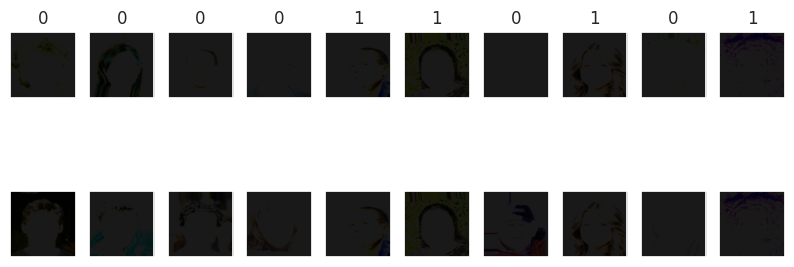

In [22]:
plt.figure(figsize=(10,10))
n = 10
for x, y in test_df.take(1):
  x1, x2 = x
  for i in range(n):
    plt.subplot(5, n, i+1)
    plt.title(f'{y[i]}')
    plt.imshow(tf.squeeze(x1[i]))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(5, n, n+i+1)
    plt.imshow(tf.squeeze(x2[i]))
    plt.xticks([])
    plt.yticks([])

In [23]:
fr_model = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=(244, 244, 3)
)
fr_model.trainable = False
fr_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_16         │ (None, 250, 250, 3)    │              0 │ input_layer_28[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d_16[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_17         │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_17[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [24]:
class SiameseModel(tf.keras.Model):
  def __init__(self, fr_model):
      super(SiameseModel, self).__init__()

      self.fr_model = fr_model
      self.d1 = tf.keras.layers.Dense(512, use_bias=False)
      self.bn1 = tf.keras.layers.BatchNormalization()
      self.d2 = tf.keras.layers.Dense(128, use_bias=False)
      self.bn2 = tf.keras.layers.BatchNormalization()
      self.out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)

      self.leaky_relu = tf.keras.layers.LeakyReLU()

  def call(self, inputs):
    x1, x2 = inputs
    x1 = self.fr_model(x1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    x2 = self.fr_model(x2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

    x = tf.keras.layers.concatenate([x1, x2])
    x = self.d1(x)
    x = self.bn1(x)
    x = self.leaky_relu(x)
    x = self.d2(x)
    x = self.bn2(x)
    x = self.leaky_relu(x)
    output = self.out(x)
    return output

  def build_model(self, dim=[244,244,3]):
    x = (tf.keras.layers.Input(dim), tf.keras.layers.Input(dim))
    return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


model = SiameseModel(fr_model)
model.build_model(dim=[244,244,3]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_30            │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer_29[0][0],  │
│                           │                        │                │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 2048)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 512)            │      1,048,576 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 512)            │          2,048 │ dense_24[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 128)            │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 128)            │         65,536 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 128)            │            512 │ dense_25[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 1)              │            129 │ leaky_re_lu_8[1][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,154,305 (31.11 MB)

 Trainable params: 1,115,521 (4.26 MB)

 Non-trainable params: 7,038,784 (26.85 MB)

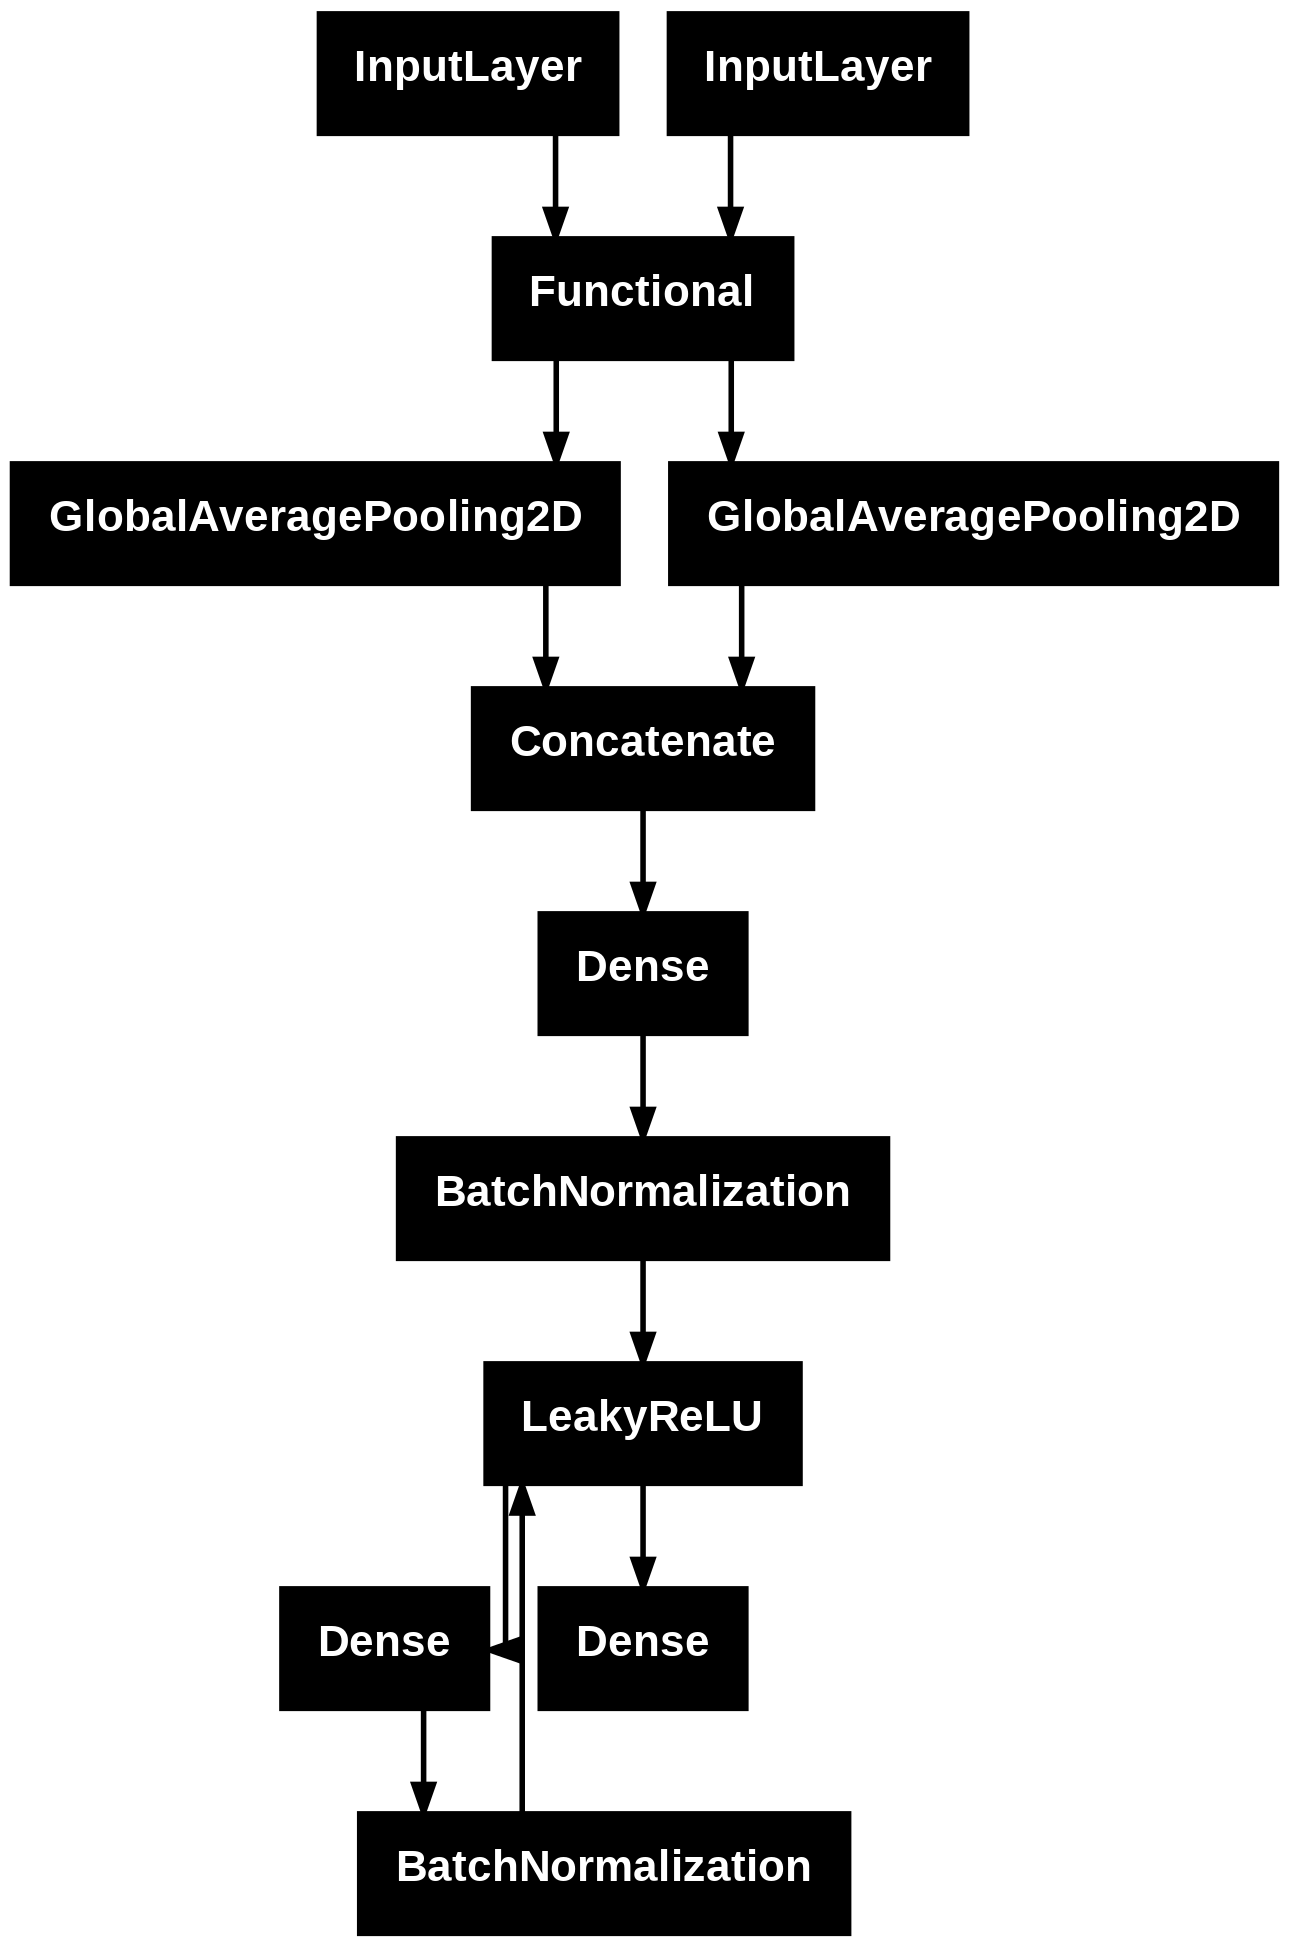

In [25]:
tf.keras.utils.plot_model(model.build_model(dim=[244,244,3]))

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
model.fit(train_df, epochs=10, validation_data=test_df)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.9333 - loss: 0.1738 - val_accuracy: 0.9653 - val_loss: 0.0947
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 221ms/step - accuracy: 0.9314 - loss: 0.1748 - val_accuracy: 0.9413 - val_loss: 0.1545
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9385 - loss: 0.1656 - val_accuracy: 0.9580 - val_loss: 0.1136
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9385 - loss: 0.1581 - val_accuracy: 0.9682 - val_loss: 0.0838
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9392 - loss: 0.1500 - val_accuracy: 0.9398 - val_loss: 0.1546
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.9432 - loss: 0.1482 - val_accuracy: 0.9632 - val_loss: 0.0958
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 221ms/step - accuracy: 0.9422 - loss: 0.1426 - val_accuracy: 0.9703 - val_loss: 0.0862
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 221ms/step - accuracy: 0.9349 -

In [90]:
import cv2

def preprocess_frame(frame, input_size=(244, 244)):
    """
    Preprocesses a single video frame for the face recognition model.
    """
    resized_frame = cv2.resize(frame, input_size)
    normalized_frame = resized_frame / 255.0
    preprocessed_frame = np.expand_dims(normalized_frame, axis=0)
    return tf.convert_to_tensor(preprocessed_frame, dtype=tf.float32)

def process_video(video_path, model, output_path=None):
    """
    Processes a video file using OpenCV's DNN-based face detection, 
    runs each face through the model, and saves the output.
    """
    # Load the DNN face detector model
    face_net = cv2.dnn.readNetFromCaffe(
        '/kaggle/input/predict-video/deploy.prototxt', 
        '/kaggle/input/predict-video/res10_300x300_ssd_iter_140000.caffemodel'
    )

    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    scores = []

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    with tqdm(total=total_frames, desc="Processing video") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
    
            # Get the frame dimensions
            h, w = frame.shape[:2]
    
            # Prepare the frame for DNN-based face detection
            blob = cv2.dnn.blobFromImage(
                frame, 
                scalefactor=1.0, 
                size=(300, 300), 
                mean=(104.0, 177.0, 123.0), 
                swapRB=False, 
                crop=False
            )
            face_net.setInput(blob)
            detections = face_net.forward()
    
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > 0.5:  # Adjust confidence threshold if needed
                    # Get the bounding box coordinates
                    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (x, y, x2, y2) = box.astype("int")
    
                    # Extract face ROI and preprocess it
                    face_roi = frame[y:y2, x:x2]
                    if face_roi.size == 0:  # Skip if ROI is invalid
                        continue
    
                    preprocessed_face = preprocess_frame(face_roi)
                    prediction = model.predict((preprocessed_face, preprocessed_face), verbose=0)
                    scores.append(prediction[0])
    
                    # Draw a bounding box and label
                    label = "Face Recognized" if prediction[0] > 0.5 else "No Face"
                    color = (0, 255, 0) if prediction[0] > 0.5 else (0, 0, 255)
                    cv2.rectangle(frame, (x, y), (x2, y2), color, 2)
                    cv2.putText(
                        frame, label, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2
                    )
            
            if output_path:
                out.write(frame)
            pbar.update(1)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    print(f"Mean prediction score: {np.mean(scores)}")
    cap.release()
    if output_path:
        out.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    
    model = model
    video_path = '/kaggle/input/predict-video/test.mp4'
    output_path = 'output_vid3.mp4'

    process_video(video_path, model, output_path=output_path)


Processing video:   0%|          | 0/2225 [00:00<?, ?it/s]

Mean prediction score: 0.9990261197090149
